Another way to parameterize sleep versus wakeful state is by calculating fold enrichment in mean daytime and nighttime activity. Comparing this parameter across genotypes might help us hypothesize the function of the *aanat2* gene in zebrafish.

In [152]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

import beeswarm as bs
# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

def pretty_activity_plot(ax, selector, selection, col, df, xlabel='time (hr)', 
                         ylabel='activity (sec / min)', lw=0.25, 
                         color=None):
    """
    Makes a pretty plot of sleep traces.  Generates the plot on axes ax,
    and then returns the updated ax.
    """
    # Make sure selection input is iterable
    if type(selection) in [str, int, float]:
        selection = [selection]
        
    # Plot time traces of column col for each fish
    for sel in selection:
        # Pull out record of interest
        df_plot = df[df[selector]==sel]

        # Generate plot
        if color is None:
            ax.plot(df_plot.zeit, df_plot[col], '-', lw=lw)
        else:
            ax.plot(df_plot.zeit, df_plot[col], '-', lw=lw, color=color)

    # Label axes
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Set axis limits
    ax.set_xlim((df_plot.zeit.min(), df_plot.zeit.max()))
    ax.set_ylim((0.0, ax.get_ylim()[1]))
    
    # Overlay night shading
    ax.fill_between(df_plot.zeit, 0.0, ax.get_ylim()[1], 
                    where=~df_plot.light, color='gray', alpha=0.3, zorder=0)    
    
    return ax

Lets read in the tidy dataset.

In [3]:
df = pd.read_csv("130315_1_minute_intervals.csv",comment="#")

In [4]:
df.head()

,fish,genotype,day,light,CLOCK,zeit,activity,window
0,FISH1,het,0,True,9.519,9.519,0.6,NaN
1,FISH1,het,0,True,9.536,9.536,1.9,NaN
2,FISH1,het,0,True,9.553,9.553,1.9,NaN
3,FISH1,het,0,True,9.569,9.569,13.4,NaN
4,FISH1,het,0,True,9.586,9.586,15.4,NaN


For this analysis, lets get individual data points for each fish and take the mean in order to compare it to the mean activity during the night, across all genotypes.

In [5]:
#First and Third days are based on the dataframe indexing. Day[1] in dataframe is the first day.
SecondDayActivity = df [(df["day"]==1) & (df["light"]==True) ].groupby(("fish","genotype"))["activity"].mean().reset_index()
FourthDayActivity = df [(df["day"]==3) & (df["light"]==True) ].groupby(("fish","genotype"))["activity"].mean().reset_index()

#This is different from the Tutorial. First and Third Nights are the ones that follow the first and third days, respectively.
SecondNightActivity = df[(df["day"]==1) & (df["light"]==False) ].groupby(("fish","genotype"))["activity"].mean().reset_index()
FourthNightActivity = df[(df["day"]==3) & (df["light"]==False) ].groupby(("fish","genotype"))["activity"].mean().reset_index()


In [6]:
CombinedSleepData =pd.concat([SecondDayActivity[["fish","genotype","activity"]],
                              SecondNightActivity[["activity"]],
                              FourthDayActivity[["activity"]],
                              FourthNightActivity[["activity"]]], axis=1)

In [7]:
CombinedSleepData.columns=["fish","genotype","MeanSecondDayActivity","MeanSecondNightActivity",
                           "MeanFourthDayActivity","MeanFourthNightActivity"]

In [8]:
CombinedSleepData.groupby("genotype").mean()

,MeanSecondDayActivity,MeanSecondNightActivity,MeanFourthDayActivity,MeanFourthNightActivity
genotype,,,,
het,4.453268,0.900623,6.699870,1.305324
mut,3.882942,2.405909,6.467198,2.841098
wt,4.989648,0.951853,6.349120,1.030118


Find ratio of activity (Day/Night)

In [9]:
MeanCombinedSleepData=CombinedSleepData.groupby("genotype").mean().reset_index()

In [10]:
MeanCombinedSleepData["RatioSecondDayNight"]=pd.Series(MeanCombinedSleepData["MeanSecondDayActivity"]/
                                                       MeanCombinedSleepData["MeanSecondNightActivity"])

MeanCombinedSleepData["RatioFourthDayNight"]=pd.Series(MeanCombinedSleepData["MeanFourthDayActivity"]/
                                                       MeanCombinedSleepData["MeanFourthNightActivity"])

In [18]:
ListOfActsSecondDay = [ CombinedSleepData.MeanSecondDayActivity[CombinedSleepData.genotype=="wt"],
             CombinedSleepData.MeanSecondDayActivity[CombinedSleepData.genotype=="het"],
            CombinedSleepData.MeanSecondDayActivity[CombinedSleepData.genotype=="mut"] ]

ListOfActsSecondNight = [ CombinedSleepData.MeanSecondNightActivity[CombinedSleepData.genotype=="wt"],
             CombinedSleepData.MeanSecondNightActivity[CombinedSleepData.genotype=="het"],
            CombinedSleepData.MeanSecondNightActivity[CombinedSleepData.genotype=="mut"] ]

ListOfActsFourthDay = [ CombinedSleepData.MeanFourthDayActivity[CombinedSleepData.genotype=="wt"],
             CombinedSleepData.MeanFourthDayActivity[CombinedSleepData.genotype=="het"],
            CombinedSleepData.MeanFourthDayActivity[CombinedSleepData.genotype=="mut"] ]

ListOfActsFourthNight = [ CombinedSleepData.MeanFourthNightActivity[CombinedSleepData.genotype=="wt"],
             CombinedSleepData.MeanFourthNightActivity[CombinedSleepData.genotype=="het"],
            CombinedSleepData.MeanFourthNightActivity[CombinedSleepData.genotype=="mut"] ]

In [88]:
max(ListOfActsSecondNight[2])

16.172999999999998

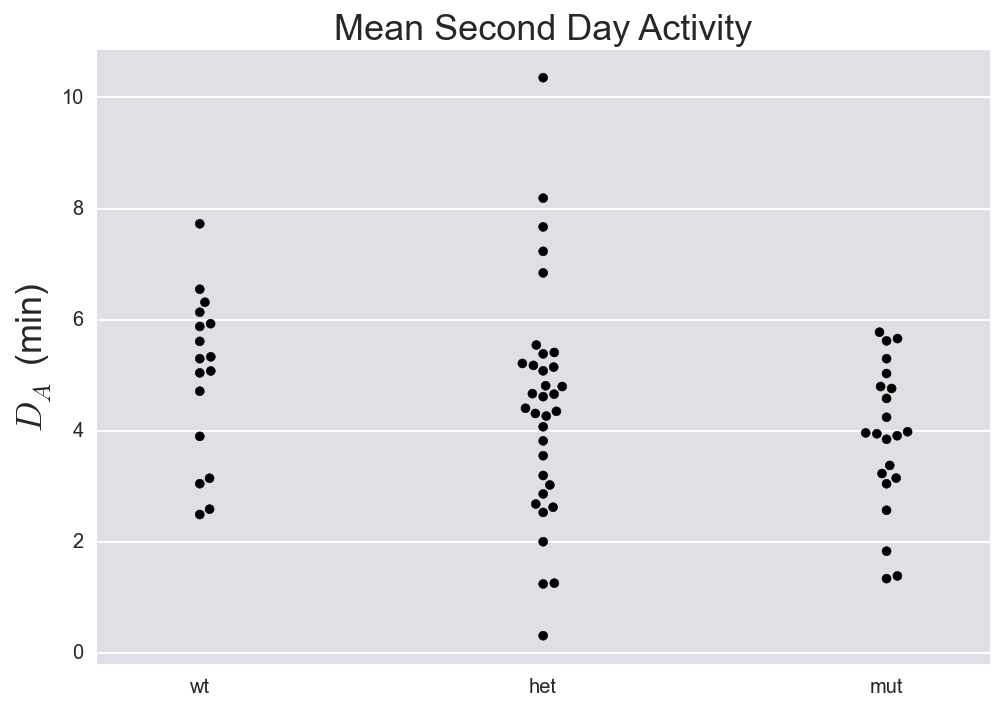

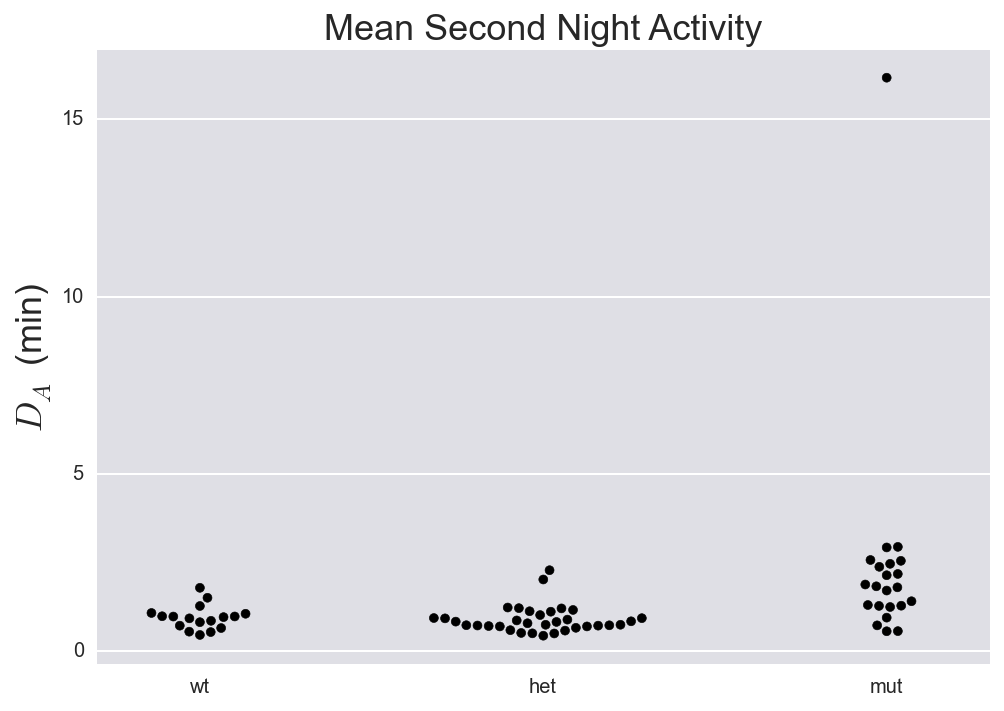

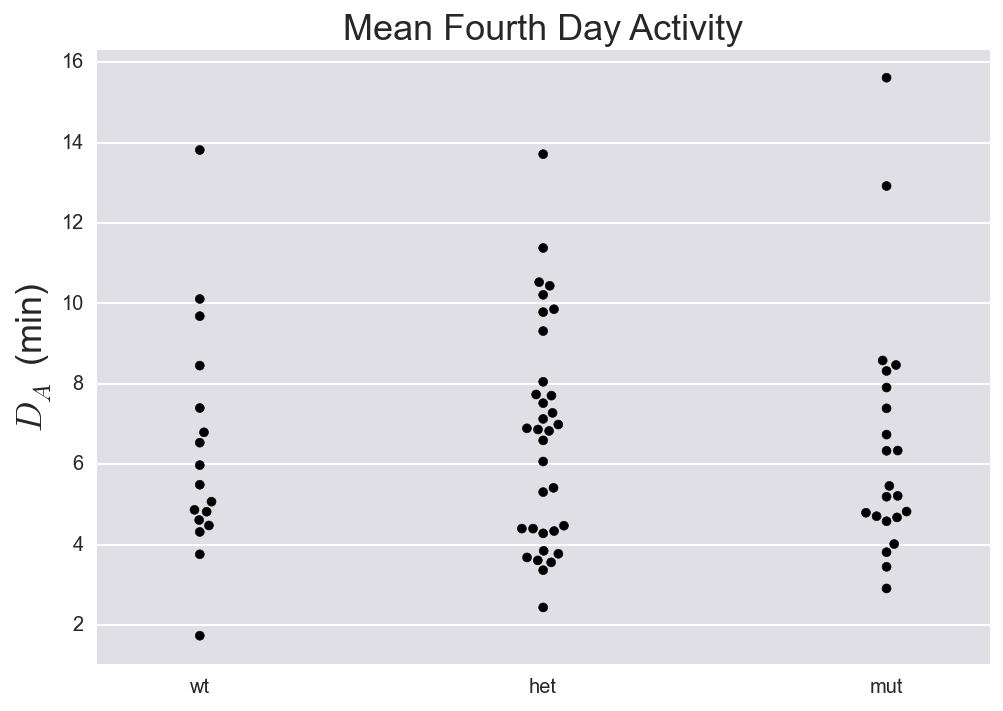

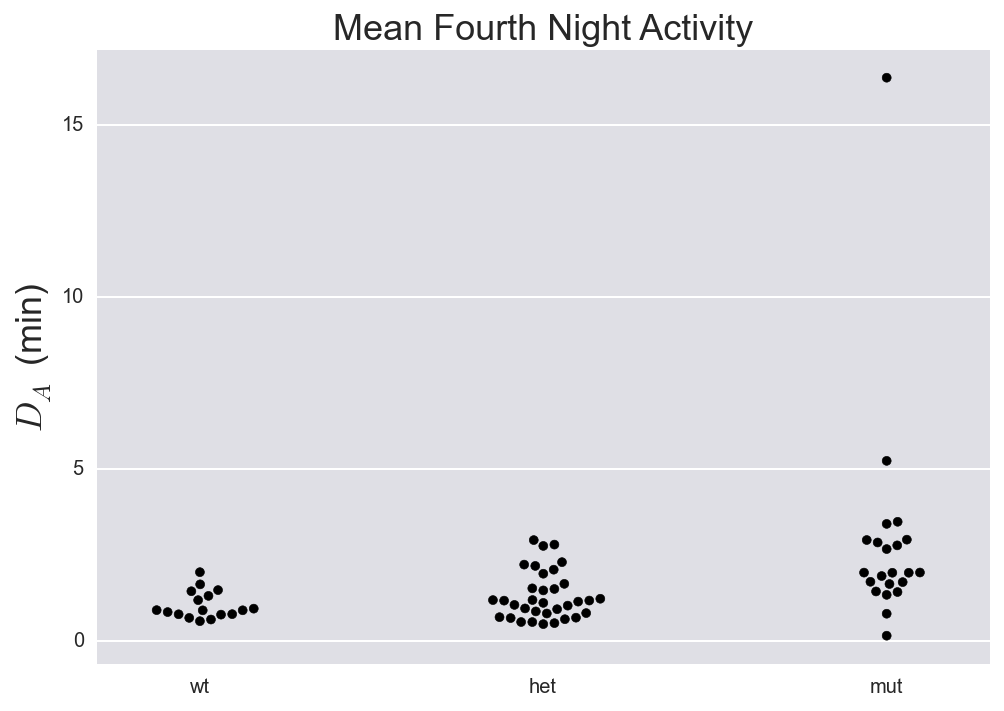

In [127]:
_=bs.beeswarm(ListOfActsSecondDay,labels = ["wt","het","mut"])
plt.ylabel("$D_A$ (min)")
plt.grid(axis="x")
plt.title("Mean Second Day Activity")

_=bs.beeswarm(ListOfActsSecondNight,labels = ["wt","het","mut"])
plt.ylabel("$D_A$ (min)")
plt.grid(axis="x")
plt.title("Mean Second Night Activity")

_=bs.beeswarm(ListOfActsFourthDay,labels = ["wt","het","mut"])
plt.ylabel("$D_A$ (min)")
plt.grid(axis="x")
plt.title("Mean Fourth Day Activity")

_=bs.beeswarm(ListOfActsFourthNight,labels = ["wt","het","mut"])
plt.grid(axis="x")
plt.title("Mean Fourth Night Activity")
plt.ylabel("$D_A$ (min)")

As can be seen in the plots above, there seem to be outliers in the mutant population that are skewing the plots for mean night time activity. Lets identify the outliers and then remove them to see how the plot looks like.

In [94]:
SecondNightOutlier=SecondNightActivity[ SecondNightActivity.activity==max(ListOfActsSecondNight[2])]

FourthNightOutlier = FourthNightActivity[FourthNightActivity.activity==max(ListOfActsFourthNight[2])]


In [95]:
SecondNightOutlier

,fish,genotype,activity
11,FISH21,mut,16.173


In [96]:
FourthNightOutlier

,fish,genotype,activity
49,FISH67,mut,16.3735


Fish21 and Fish67 seem to have very high mean activity during the second and fourth night, respectively. Lets remove them from the dataset and plot the mean activities again.

In [139]:
FilteredSecondDayActivity = SecondDayActivity.drop(SecondDayActivity.index[[11,49]])
FilteredSecondNightActivity = SecondNightActivity.drop(SecondDayActivity.index[[11,49]])
FilteredFourthDayActivity = FourthDayActivity.drop(SecondDayActivity.index[[11,49]])
FilteredFourthNightActivity = FourthNightActivity.drop(SecondDayActivity.index[[11,49]])

In [140]:
FilteredCombinedSleepData =pd.concat([FilteredSecondDayActivity[["fish","genotype","activity"]],
                                      FilteredSecondNightActivity[["activity"]],
                                      FilteredFourthDayActivity[["activity"]],
                                      FilteredFourthNightActivity[["activity"]]], axis=1)

In [141]:
FilteredCombinedSleepData.columns=["fish","genotype","MeanSecondDayActivity","MeanSecondNightActivity",
                           "MeanFourthDayActivity","MeanFourthNightActivity"]

In [145]:
FilteredListOfActsSecondDay = [ FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="wt"],
             FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="het"],
            FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="mut"] ]

FilteredListOfActsSecondNight = [ FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="wt"],
             FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="het"],
            FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="mut"] ]

FilteredListOfActsFourthDay = [ FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="wt"],
             FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="het"],
            FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="mut"] ]

FilteredListOfActsFourthNight = [ FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="wt"],
             FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="het"],
            FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="mut"] ]

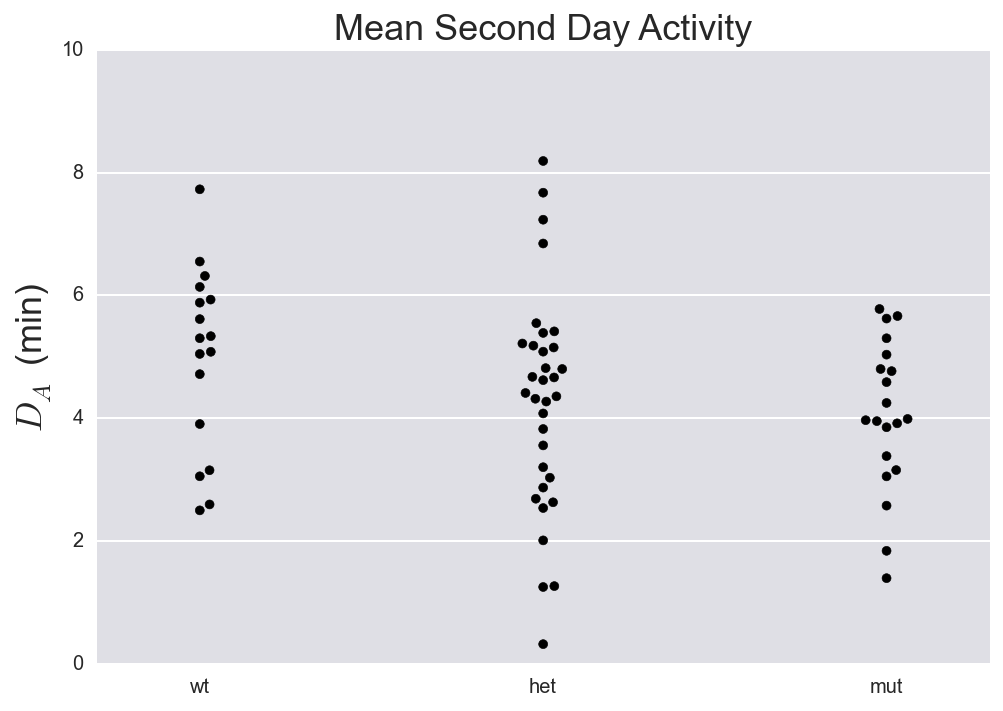

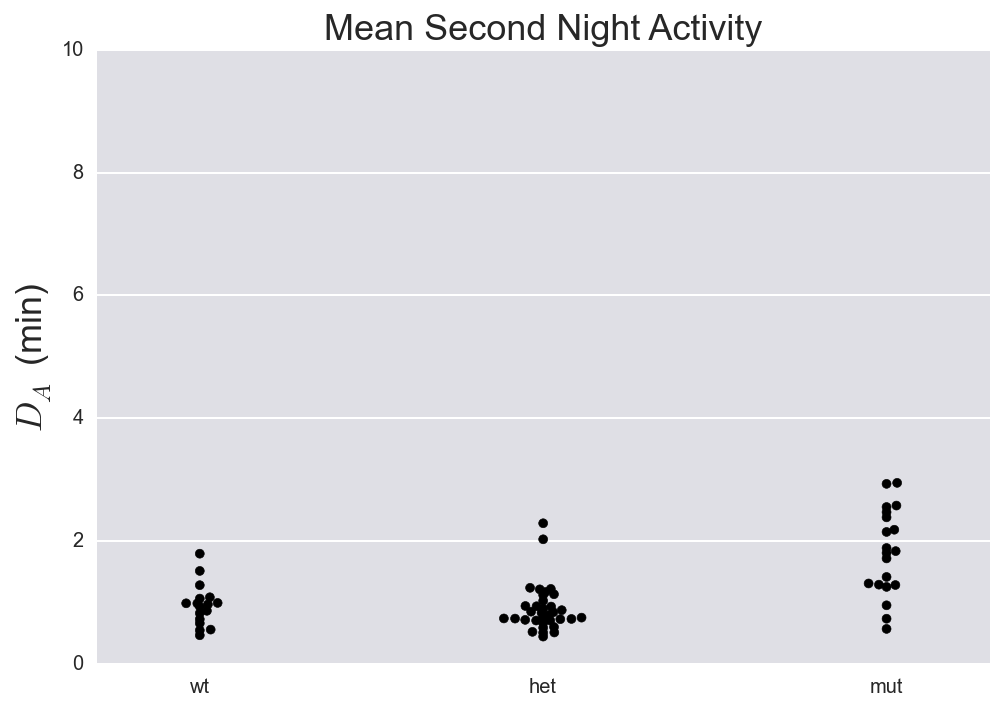

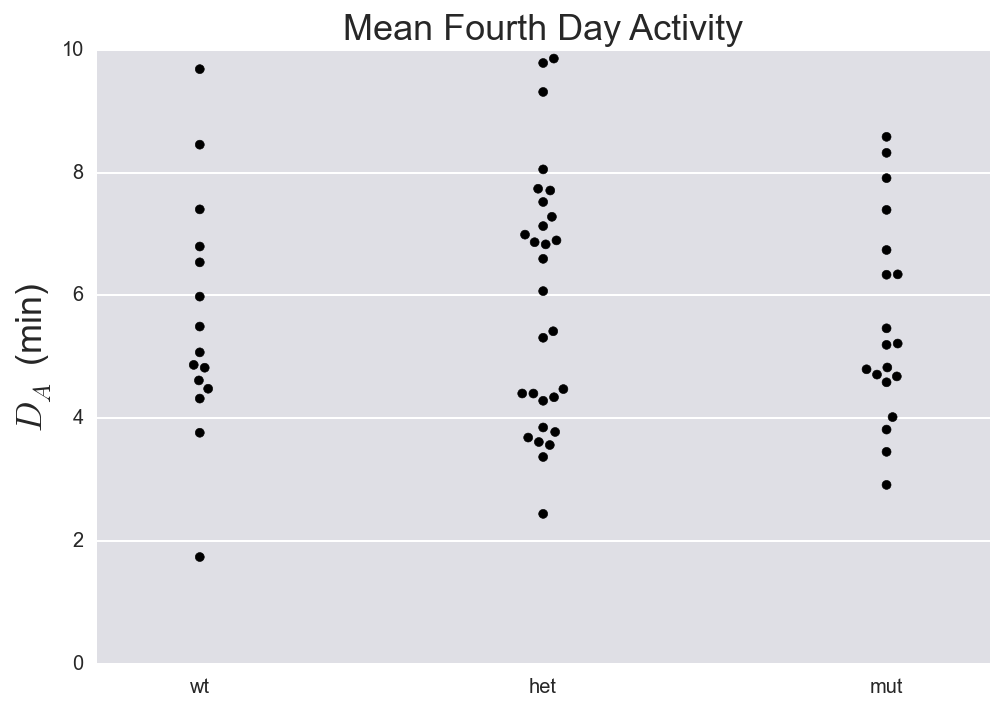

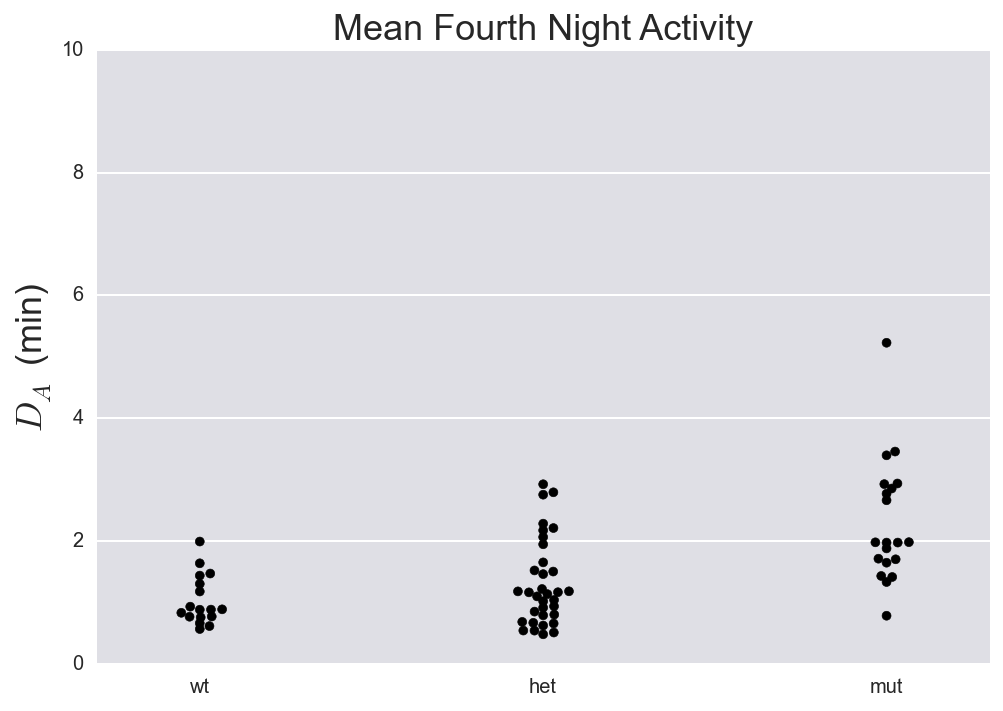

In [148]:
_=bs.beeswarm(FilteredListOfActsSecondDay,labels = ["wt","het","mut"])
plt.ylabel("$D_A$ (min)")
plt.grid(axis="x")
plt.ylim(0,10)
plt.title("Mean Second Day Activity")

_=bs.beeswarm(FilteredListOfActsSecondNight,labels = ["wt","het","mut"])
plt.ylabel("$D_A$ (min)")
plt.grid(axis="x")
plt.ylim(0,10)
plt.title("Mean Second Night Activity")

_=bs.beeswarm(FilteredListOfActsFourthDay,labels = ["wt","het","mut"])
plt.ylabel("$D_A$ (min)")
plt.grid(axis="x")
plt.ylim(0,10)
plt.title("Mean Fourth Day Activity")

_=bs.beeswarm(FilteredListOfActsFourthNight,labels = ["wt","het","mut"])
plt.grid(axis="x")
plt.title("Mean Fourth Night Activity")
plt.ylim(0,10)
plt.ylabel("$D_A$ (min)")

There are subtle differences between the two days and nights when compared across genotypes. Lets quantify them!

In [149]:
def student_t(mu, x):
    """
    Returns the Student-t distribution for values of mu with data x.
    We could use scipy.stats for this, but we'll do it ourselves.
    """
    # Number of data
    n = len(x)
    
    # Mean of data
    x_mean = x.mean()
    
    # Compute r^2
    r2 = ((x - x_mean)**2).sum() / n
    
    # Compute the mu-dependent part
    t = (1.0 + (mu - x_mean)**2 / r2)**(-n / 2.0)
    
    # Normalize and return
    return -scipy.special.beta(-0.5, n / 2.0) / 2.0 / np.pi / np.sqrt(r2) * t

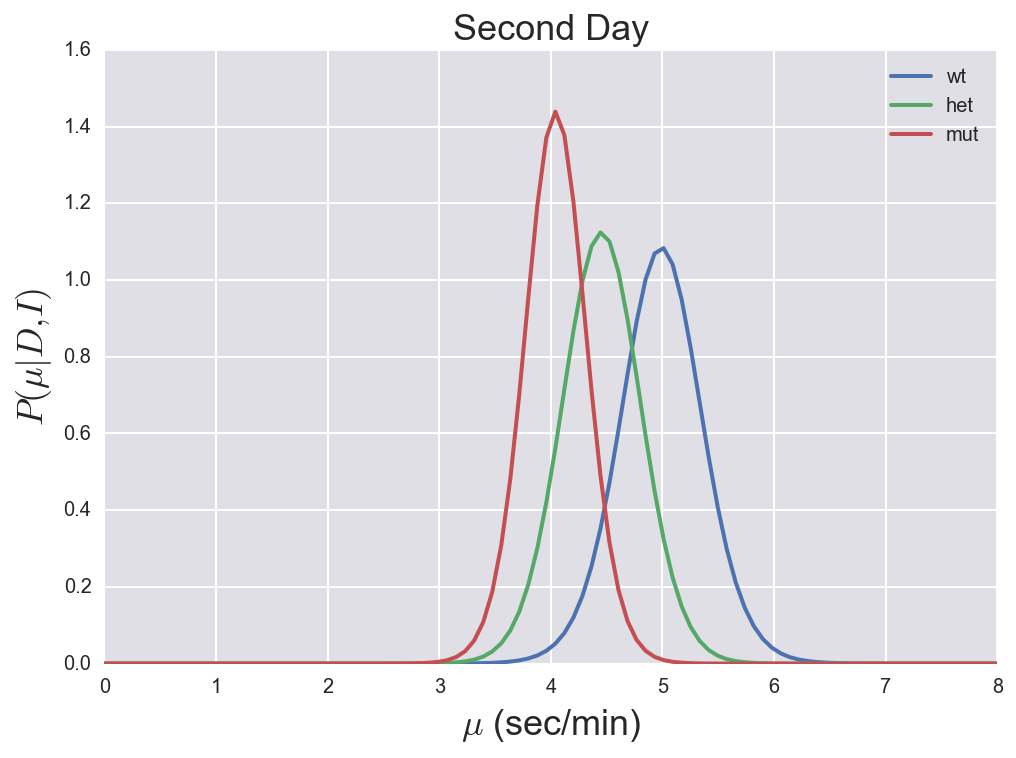

In [162]:
mu = np.linspace(0.0, 8.0,100)

post_wt= student_t(mu,FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="wt"])
post_het= student_t(mu,FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="het"])
post_mut= student_t(mu,FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="mut"])

plt.plot(mu, post_wt)
plt.plot(mu, post_het)
plt.plot(mu, post_mut)
plt.xlabel(r'$\mu$ (sec/min)')
plt.ylabel(r'$P(\mu|D,I)$')
plt.title("Second Day")
lg = plt.legend(('wt', 'het', 'mut'), loc='upper right')

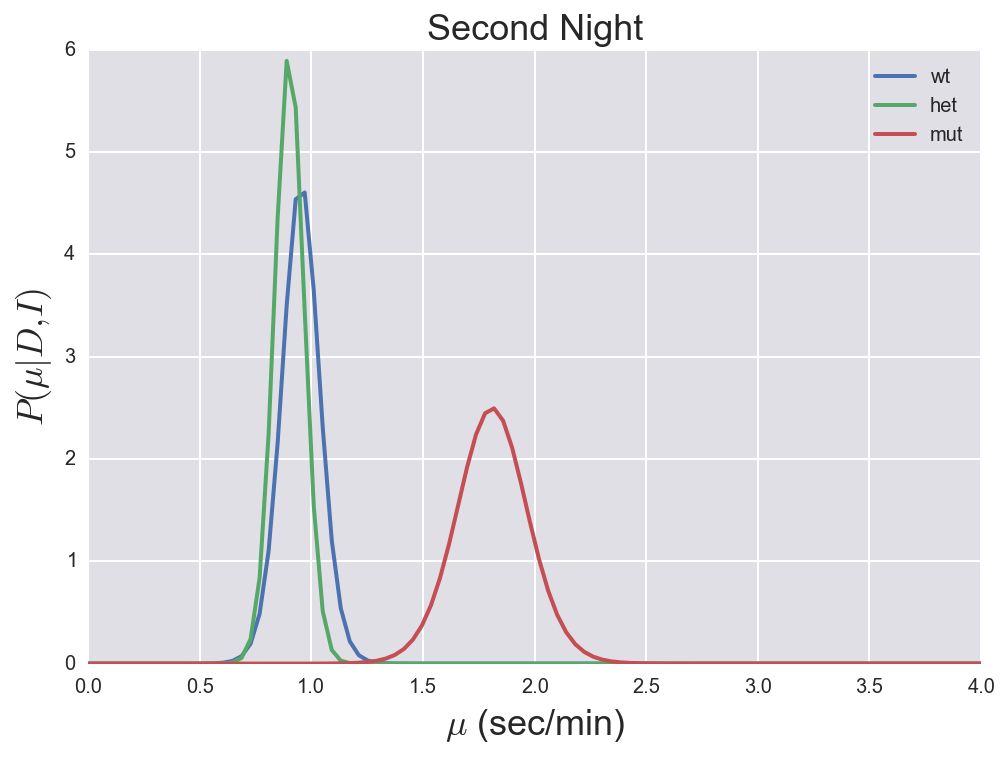

In [183]:
mu = np.linspace(0.0, 4.0,100)

post_wt= student_t(mu,FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="wt"])
post_het= student_t(mu,FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="het"])
post_mut= student_t(mu,FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="mut"])

plt.plot(mu, post_wt)
plt.plot(mu, post_het)
plt.plot(mu, post_mut)
plt.xlabel(r'$\mu$ (sec/min)')
plt.ylabel(r'$P(\mu|D,I)$')
plt.title("Second Night")
lg = plt.legend(('wt', 'het', 'mut'), loc='upper right')

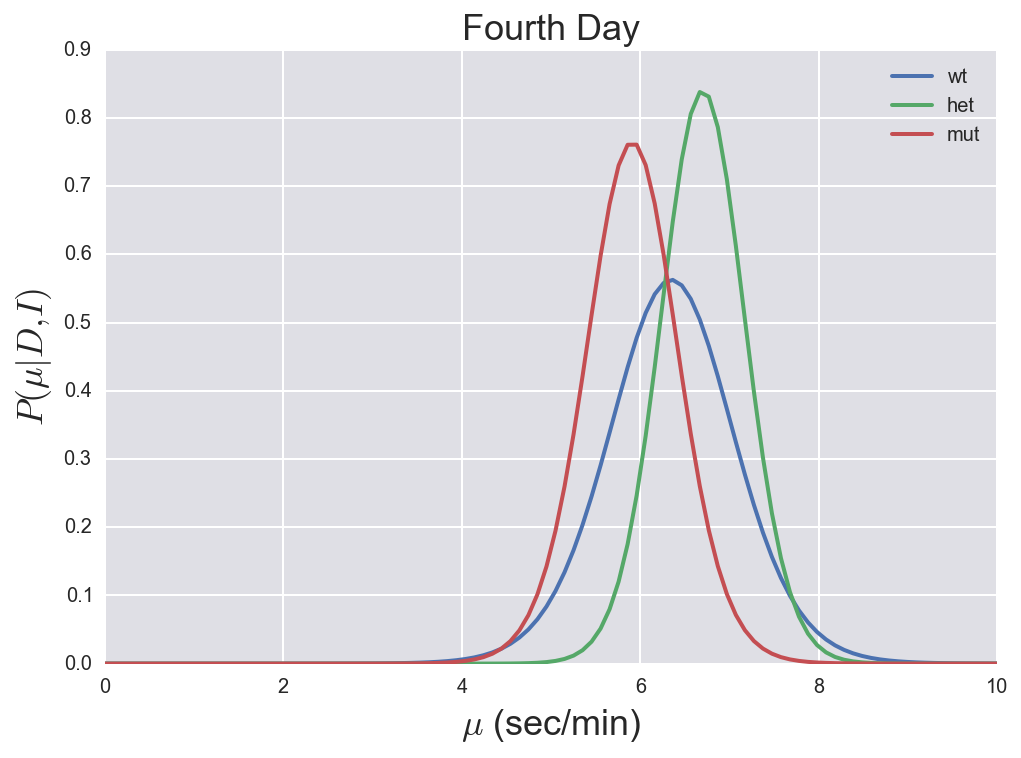

In [164]:
mu = np.linspace(0.0, 10.0,100)

post_wt= student_t(mu,FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="wt"])
post_het= student_t(mu,FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="het"])
post_mut= student_t(mu,FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="mut"])

plt.plot(mu, post_wt)
plt.plot(mu, post_het)
plt.plot(mu, post_mut)
plt.xlabel(r'$\mu$ (sec/min)')
plt.ylabel(r'$P(\mu|D,I)$')
plt.title("Fourth Day")
lg = plt.legend(('wt', 'het', 'mut'), loc='upper right')

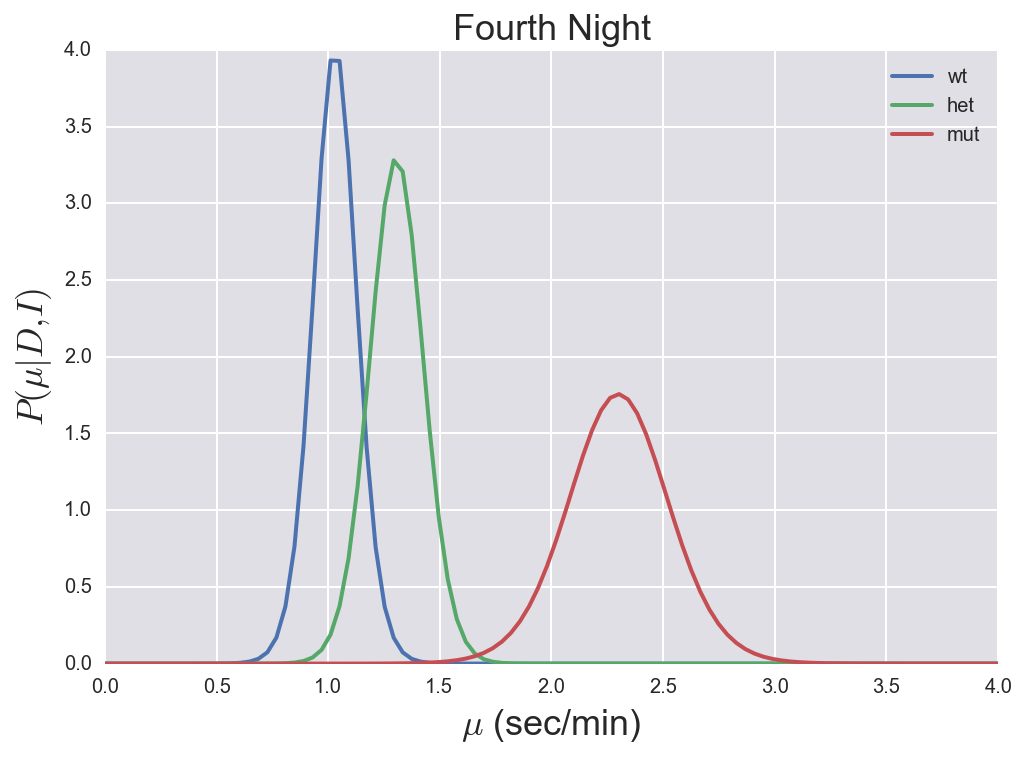

In [184]:
mu = np.linspace(0.0, 4.0,100)

post_wt= student_t(mu,FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="wt"])
post_het= student_t(mu,FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="het"])
post_mut= student_t(mu,FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="mut"])

plt.plot(mu, post_wt)
plt.plot(mu, post_het)
plt.plot(mu, post_mut)
plt.xlabel(r'$\mu$ (sec/min)')
plt.ylabel(r'$P(\mu|D,I)$')
plt.title("Fourth Night")
lg = plt.legend(('wt', 'het', 'mut'), loc='upper right')

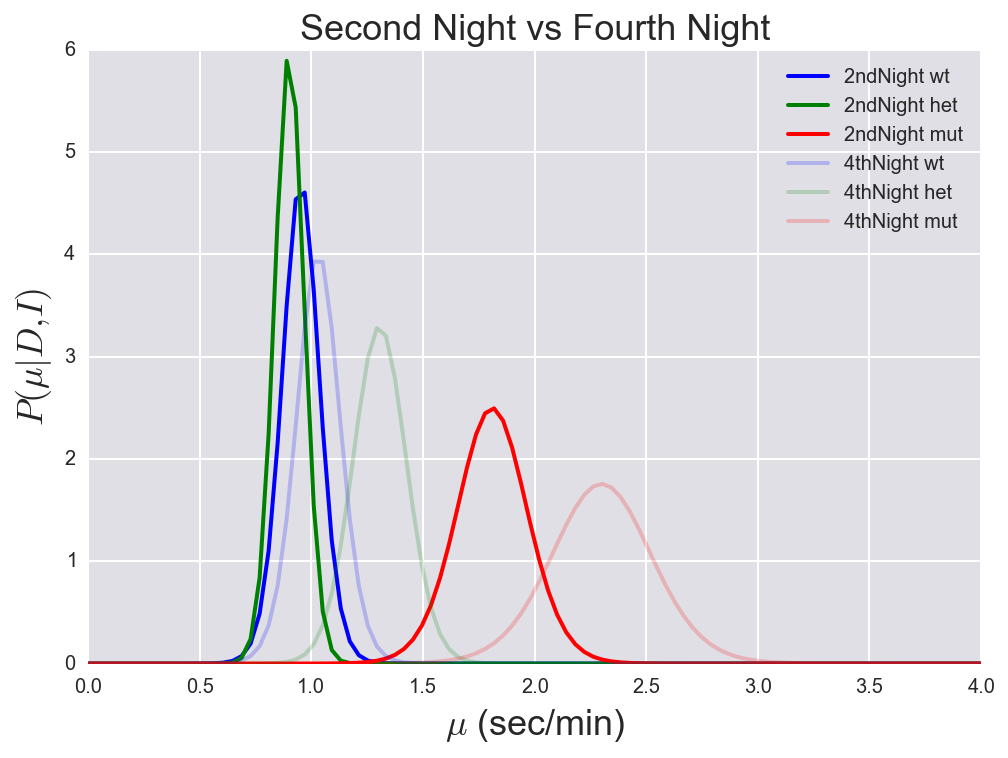

In [178]:
mu = np.linspace(0.0, 4.0,100)

SecondNightPostWT= student_t(mu,FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="wt"])
SecondNightPostHET= student_t(mu,FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="het"])
SecondNightPostMUT= student_t(mu,FilteredCombinedSleepData.MeanSecondNightActivity[FilteredCombinedSleepData.genotype=="mut"])

FourthNightPostWT= student_t(mu,FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="wt"])
FourthNightPostHET= student_t(mu,FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="het"])
FourthNightPostMUT= student_t(mu,FilteredCombinedSleepData.MeanFourthNightActivity[FilteredCombinedSleepData.genotype=="mut"])


plt.plot(mu, SecondNightPostWT, lw=2, color="blue")
plt.plot(mu, SecondNightPostHET,lw=2,color="green")
plt.plot(mu, SecondNightPostMUT,lw=2,color="red")
plt.plot(mu, FourthNightPostWT,lw=2,color="blue",alpha=0.2)
plt.plot(mu, FourthNightPostHET,lw=2,color="green",alpha=0.2)
plt.plot(mu, FourthNightPostMUT,lw=2,color="red",alpha=0.2)

plt.xlabel(r'$\mu$ (sec/min)')
plt.ylabel(r'$P(\mu|D,I)$')
plt.title("Second Night vs Fourth Night")

lg = plt.legend(('2ndNight wt', '2ndNight het', '2ndNight mut','4thNight wt', '4thNight het', '4thNight mut'), loc='upper right')


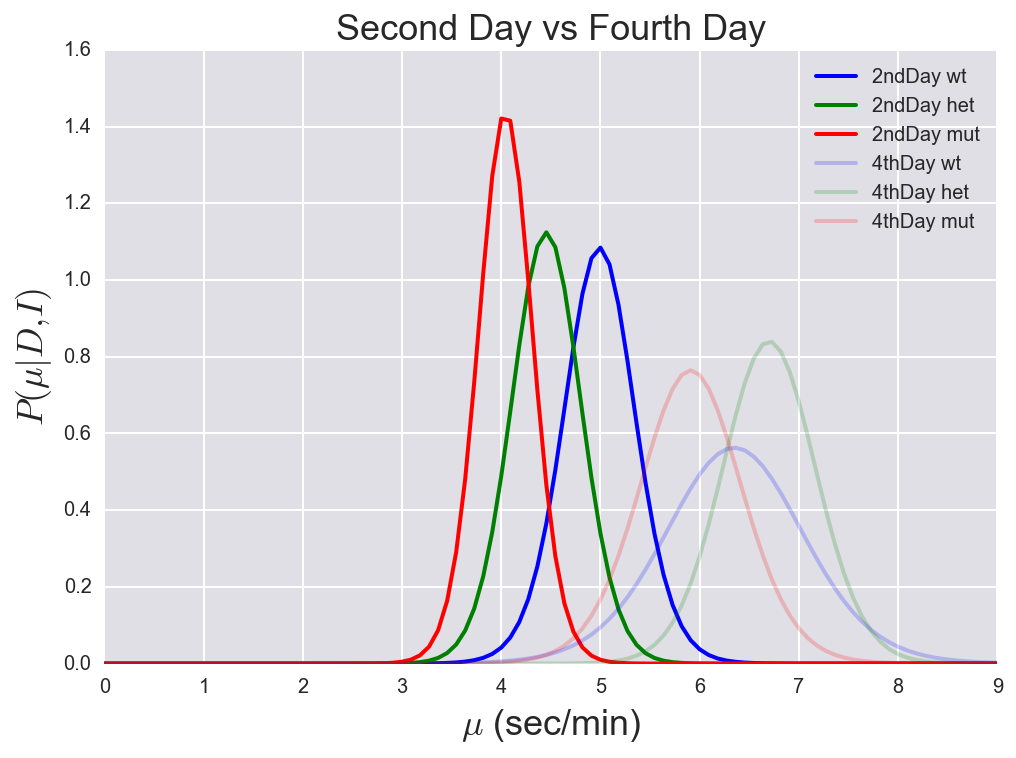

In [185]:
mu = np.linspace(0.0, 9.0,100)

SecondDayPostWT= student_t(mu,FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="wt"])
SecondDayPostHET= student_t(mu,FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="het"])
SecondDayPostMUT= student_t(mu,FilteredCombinedSleepData.MeanSecondDayActivity[FilteredCombinedSleepData.genotype=="mut"])

FourthDayPostWT= student_t(mu,FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="wt"])
FourthDayPostHET= student_t(mu,FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="het"])
FourthDayPostMUT= student_t(mu,FilteredCombinedSleepData.MeanFourthDayActivity[FilteredCombinedSleepData.genotype=="mut"])


plt.plot(mu, SecondDayPostWT, lw=2, color="blue")
plt.plot(mu, SecondDayPostHET,lw=2,color="green")
plt.plot(mu, SecondDayPostMUT,lw=2,color="red")
plt.plot(mu, FourthDayPostWT,lw=2,color="blue",alpha=0.2)
plt.plot(mu, FourthDayPostHET,lw=2,color="green",alpha=0.2)
plt.plot(mu, FourthDayPostMUT,lw=2,color="red",alpha=0.2)

plt.xlabel(r'$\mu$ (sec/min)')
plt.ylabel(r'$P(\mu|D,I)$')
plt.title("Second Day vs Fourth Day")

lg = plt.legend(('2ndDay wt', '2ndDay het', '2ndDay mut','4thDay wt', '4thDay het', '4thDay mut'), loc='upper right')

